In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tamil_offensive_full_train.csv', delimiter='\t', names=['sentence','classes','nan'])
train = train.drop(columns=['nan'])
train.head()

,sentence,classes
0,movie vara level la Erika poguthu,Not_offensive
1,I love Ajith Kumar Vivegam movie inki mjy bht ...,not-Tamil
2,Padam nalla comedy padama irukum polaye..,Not_offensive
3,karthick subburaj anne .... intha padam vetri ...,Not_offensive
4,கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁,Not_offensive


In [4]:
val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tamil_offensive_full_dev.csv', delimiter='\t', names=['sentence','classes','nan'])
val = val.drop(columns=['nan'])
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tamil_offensive_full_test.csv',delimiter='\t',names=['sentence'])

In [5]:
test.head(4)

,sentence
0,14.12.2018 epo trailer pathutu irken ... Semay...
1,Paka thana poro movie la Enna irukunu
2,“U kena tunggu lebih lama lagi untuk tahu saya...
3,Suriya anna vera level anna mass


In [6]:
train.count()

sentence    35139
classes     35139
dtype: int64

In [8]:
train['classes'].apply(len).max()

36

In [9]:
train['sentence'].apply(len).max()

1149

In [10]:
set(train['classes']) 

{'Not_offensive',
 'Offensive_Targeted_Insult_Group',
 'Offensive_Targeted_Insult_Individual',
 'Offensive_Targeted_Insult_Other',
 'Offensive_Untargetede',
 'not-Tamil'}

In [11]:
encode_dict = {}

def encode_cat(x):
  if x not in encode_dict.keys():
    encode_dict[x] = len(encode_dict)
  return encode_dict[x]

train['encode_cat'] = train['classes'].apply(lambda x: encode_cat(x))
val['encode_cat'] = val['classes'].apply(lambda x: encode_cat(x))

In [12]:
train.head(9)

,sentence,classes,encode_cat
0,movie vara level la Erika poguthu,Not_offensive,0
1,I love Ajith Kumar Vivegam movie inki mjy bht ...,not-Tamil,1
2,Padam nalla comedy padama irukum polaye..,Not_offensive,0
3,karthick subburaj anne .... intha padam vetri ...,Not_offensive,0
4,கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁,Not_offensive,0
5,ippo intha trailer ah parkuravana oru like pod...,Not_offensive,0
6,En thalaivan yogi babu irukkaar. Padam vera le...,Not_offensive,0
7,Nerkonda parvai... Sema sema sema trailer,Not_offensive,0
8,ஏய் இது 96 யார் ஏமாத்தறீங்க? செம பின்னிட்டீங்க,Not_offensive,0


In [13]:
def clean(df):
    df['sentence'] = df['sentence'].apply(lambda x: x.lower())
    df['sentence'] = df['sentence'].apply(lambda x: re.sub(r' +', ' ',x))
    df['sentence'] = df['sentence'].apply(lambda x: re.sub("[!@#$+%*:()'-]", ' ',x))
    df['sentence'] = df['sentence'].str.replace('\d+', '')

clean(train)
clean(val)
clean(test)

In [14]:
max_features = 2000
max_len = 512
tokenizer = Tokenizer(num_words=max_features, split=' ')

In [15]:
tokenizer.fit_on_texts(train['sentence'].values)
X_train = tokenizer.texts_to_sequences(train['sentence'].values)
# vocab_size = len(tokenizer.word_index) + 1
X_train = pad_sequences(X_train,padding = 'post', maxlen=max_len)

In [16]:
tokenizer.fit_on_texts(val['sentence'].values)
X_val = tokenizer.texts_to_sequences(val['sentence'].values)
# vocab_size = len(tokenizer.word_index) + 1
X_val = pad_sequences(X_val,padding = 'post', maxlen=max_len)

In [17]:
tokenizer.fit_on_texts(test['sentence'].values)
X_test = tokenizer.texts_to_sequences(test['sentence'].values)
# vocab_size = len(tokenizer.word_index) + 1
X_test = pad_sequences(X_test,padding = 'post', maxlen=max_len)

In [18]:
train['sentence'].apply(len).max()

1124

In [19]:
train.describe()

,encode_cat
count,35139.000000
mean,0.949714
std,1.684117
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,5.000000


In [29]:
y_train = train['encode_cat']
y_val = val['encode_cat']

In [30]:
Y_train = pd.get_dummies(y_train).values
Y_val = pd.get_dummies(y_val).values
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape)

(35139, 512) (35139, 6)
(4388, 512) (4388, 6)
(4392, 512)


In [21]:
from keras.layers import Layer
from keras.layers import Input
from keras.models import Model
from tensorflow.keras import backend as K

class attention(Layer):
    def __init__(self):
        super(attention,self).__init__()

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [22]:
!wget --header="Host: nlp.stanford.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: _ga=GA1.2.456156586.1539718115; _gid=GA1.2.491677602.1539718115; _gat=1" --header="Connection: keep-alive" "https://nlp.stanford.edu/data/glove.6B.zip" -O "glove.6B.zip" -c

--2021-01-08 14:14:13--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-01-08 14:14:13--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  1.98MB/s    in 6m 28s  

2021-01-08 14:20:41 (2.12 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [23]:
 !unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [24]:
 from numpy import array
 from numpy import asarray
 from numpy import zeros

 embeddings_index = dict()

 glove_file = open('glove.6B.100d.txt', encoding="utf8")

 for line in glove_file:
     records = line.split()
     word = records[0]
     vector_dimensions = asarray(records[1:], dtype='float32')
     embeddings_index[word] = vector_dimensions
 glove_file.close()

 print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [25]:
word_index = tokenizer.word_index
print(len(word_index))


num_words = min(max_features, len(word_index)) + 1
print(num_words)

embedding_dim = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

77584
2001


In [26]:
K.clear_session()
from keras.regularizers import l2
from keras.initializers import Constant
embed_dim = 100
lstm_out = 128
# model = Sequential()
inputs = Input(shape=(512,))
x = Embedding(num_words, embed_dim,embeddings_initializer=Constant(embedding_matrix),input_length = X_train.shape[1])(inputs)
att_in = Bidirectional(LSTM(lstm_out,return_sequences=True, dropout=0.2))(x)
att_out = attention()(att_in)
d = Dropout(0.2)(att_out)
outputs = Dense(6, activation='softmax')(d)
model = Model(inputs,outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 100)          200100    
_________________________________________________________________
bidirectional (Bidirectional (None, 512, 256)          234496    
_________________________________________________________________
attention (attention)        (None, 256)               768       
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 1542      
Total params: 436,906
Trainable params: 436,906
Non-trainable params: 0
_______________________________________________________

In [27]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.encode_cat.values),
                                                  train.encode_cat.values)
class_weights = dict(enumerate(class_weights))

In [32]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [33]:
history = model.fit(X_train, Y_train,batch_size = 128, validation_data=(X_val,Y_val), epochs=10, verbose=2)

Epoch 1/10
275/275 - 36s - loss: 0.9807 - accuracy: 0.7210 - val_loss: 0.9623 - val_accuracy: 0.7270
Epoch 2/10
275/275 - 26s - loss: 0.8151 - accuracy: 0.7362 - val_loss: 1.0153 - val_accuracy: 0.7083
Epoch 3/10
275/275 - 27s - loss: 0.7506 - accuracy: 0.7502 - val_loss: 1.0432 - val_accuracy: 0.7072
Epoch 4/10
275/275 - 27s - loss: 0.7186 - accuracy: 0.7579 - val_loss: 1.0931 - val_accuracy: 0.6923
Epoch 5/10
275/275 - 27s - loss: 0.6884 - accuracy: 0.7653 - val_loss: 1.1248 - val_accuracy: 0.6946
Epoch 6/10
275/275 - 27s - loss: 0.6685 - accuracy: 0.7729 - val_loss: 1.1139 - val_accuracy: 0.6905
Epoch 7/10
275/275 - 27s - loss: 0.6484 - accuracy: 0.7780 - val_loss: 1.2129 - val_accuracy: 0.6846
Epoch 8/10
275/275 - 27s - loss: 0.6299 - accuracy: 0.7808 - val_loss: 1.1864 - val_accuracy: 0.6866
Epoch 9/10
275/275 - 27s - loss: 0.6155 - accuracy: 0.7868 - val_loss: 1.2481 - val_accuracy: 0.6962
Epoch 10/10
275/275 - 27s - loss: 0.5977 - accuracy: 0.7912 - val_loss: 1.2419 - val_accura

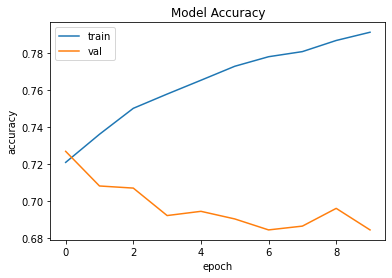

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'])
#plt.show()
plt.savefig('Model_accuracy.png', dpi=600)

In [35]:
# score = model.evaluate(X_test,verbose=1)
predictions = np.argmax(model.predict(X_val),axis = -1)

# print("val score is {}".format(score[0]))
# print("val Accuracy is {}".format(score[1]))

In [36]:
_, train_acc = model.evaluate(X_train, Y_train, verbose=0)
_, val_acc = model.evaluate(X_val, Y_val, verbose=0)

In [37]:
print(val_acc)
print(train_acc)

0.6845943331718445
0.8074219822883606


In [38]:
rounded_predictions = np.argmax(model.predict(X_test, batch_size=128, verbose=0),axis = -1)
print(rounded_predictions)

[0 0 0 ... 0 0 0]


In [39]:
import numpy as np
rounded_labels=np.argmax(Y_val, axis=1)

In [40]:
from sklearn.metrics import classification_report
print(classification_report(rounded_labels, predictions))

              precision    recall  f1-score   support

           0       0.73      0.93      0.82      3193
           1       0.05      0.02      0.03       172
           2       0.00      0.00      0.00        65
           3       0.15      0.04      0.06       295
           4       0.05      0.01      0.02       356
           5       0.18      0.06      0.09       307

    accuracy                           0.68      4388
   macro avg       0.19      0.18      0.17      4388
weighted avg       0.56      0.68      0.61      4388



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
a = {'id':[i for i in range(4392)]}
a = pd.DataFrame(a)

df = pd.DataFrame({'id':a.id,'labels':rounded_predictions})
df.labels = df.labels.apply({0:'Not_offensive',4:'Offensive_Untargetede',3:'Offensive_Targeted_Insult_Group',
5:'Offensive_Targeted_Insult_Individual',1:'not-Tamil',2:'Offensive_Targeted_Insult_Other'}.get)
df

,id,labels
0,0,Not_offensive
1,1,Not_offensive
2,2,Not_offensive
3,3,Not_offensive
4,4,Not_offensive
...,...,...
4387,4387,Not_offensive
4388,4388,Not_offensive
4389,4389,Not_offensive
4390,4390,Not_offensive


In [42]:
df.to_csv('LSTM_with_attention_Tamil_submission.csv',index=False)
from google.colab import files
files.download("LSTM_with_attention_Tamil_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>